# OHLC Verilerinden hisse tahminlemesi

# Kütüphanelerin alınması

In [1]:
#!python3 -m pip install matplotlib sklearn keras pandas tensorflow pandas_datareader

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 
import math
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import LSTM,Dense, Activation, Dropout
from keras.callbacks import ModelCheckpoint,EarlyStopping
import pandas_datareader.data as web
from dateutil.relativedelta import relativedelta
import datetime

Using TensorFlow backend.


In [3]:
def veri_kaydirmaca(hisse_verisi, gun_sayisi): # Gün sayısı kadar uzat T+1...
    data_X, data_Y = [], []
    for i in range(len(hisse_verisi)-gun_sayisi-1):
        a = hisse_verisi[i:(i+gun_sayisi), 0]
        data_X.append(a)
        data_Y.append(hisse_verisi[i + gun_sayisi, 0])
    return np.array(data_X), np.array(data_Y)

# Parametreler

In [4]:
hisse_kodu = 'ISCTR.IS'
yil = 5
gun_sayisi = 1
ag_katman_yapisi = [128, 128, 32, 1]
d = 0.2
train=True
verbose=2
np.random.seed(13)

# Veri indirme

In [5]:
def veri_al(hisse_kodu):
    baslangic = datetime.date.today() - relativedelta(years=yil)
    bitis = datetime.date.today()
    df = web.DataReader(hisse_kodu, "yahoo", baslangic, bitis).dropna()
    df.drop(['Volume'], 1, inplace=True)    
    df.drop(['Adj Close'], 1, inplace=True)        
    return df

In [6]:
hisse_verisi = veri_al(hisse_kodu)

In [7]:
hisse_verisi_np = np.arange(1, len(hisse_verisi) + 1, 1)

In [8]:
def plot_stock(df):
    print(df.tail())
    plt.figure(figsize=(16, 7))
    plt.plot(df['Close'], color='red', label='Close')
    plt.legend(loc='best')
    plt.show()

            High   Low  Open  Close
Date                               
2018-10-15  4.26  4.10  4.10   4.21
2018-10-16  4.34  4.19  4.20   4.25
2018-10-17  4.37  4.28  4.31   4.34
2018-10-18  4.43  4.25  4.35   4.29
2018-10-19  4.34  4.17  4.31   4.17


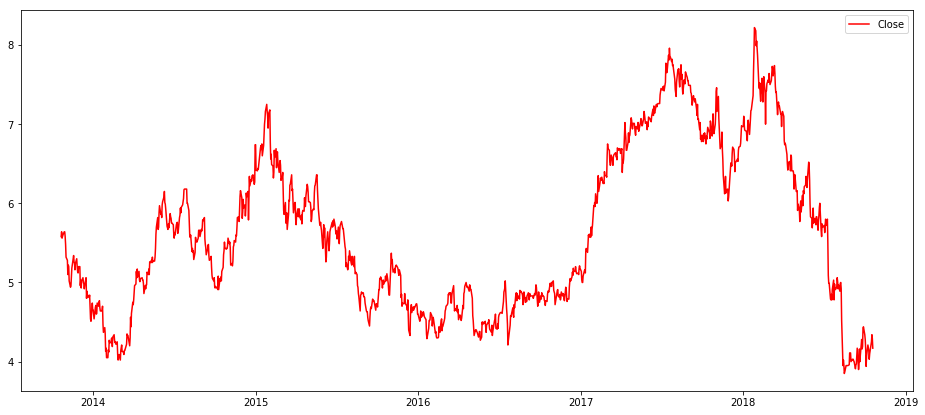

In [9]:
plot_stock(hisse_verisi)

In [10]:
OHLC_ortalamasi = hisse_verisi.mean(axis = 1)
HLC_ortalamasi = hisse_verisi[['High', 'Low', 'Close']].mean(axis = 1)
kapanis_degeri = hisse_verisi[['Close']]

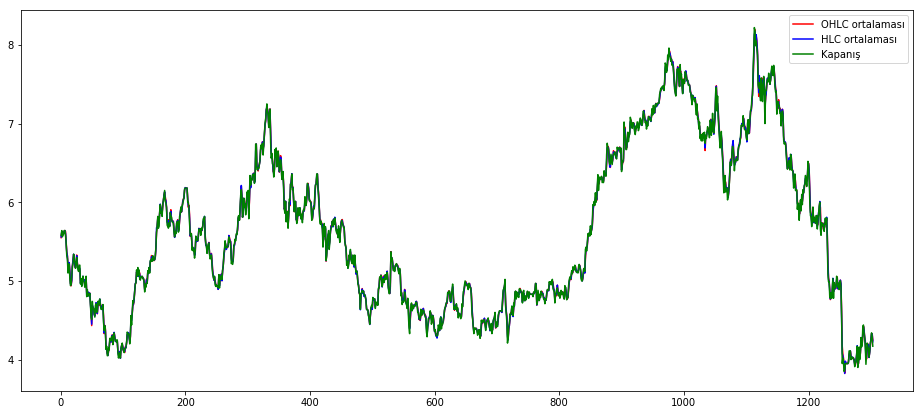

In [11]:
plt.figure(figsize=(16, 7))
plt.plot(hisse_verisi_np, OHLC_ortalamasi, 'r', label = 'OHLC ortalaması')
plt.plot(hisse_verisi_np, HLC_ortalamasi, 'b', label = 'HLC ortalaması')
plt.plot(hisse_verisi_np, kapanis_degeri, 'g', label = 'Kapanış')
plt.legend(loc = 'upper right')
plt.show()

# Normalize

In [12]:
OHLC_ortalamasi = np.reshape(OHLC_ortalamasi.values, (len(OHLC_ortalamasi),1)) 
scaler = MinMaxScaler(feature_range=(0, 1))
OHLC_ortalamasi = scaler.fit_transform(OHLC_ortalamasi)

# Train - Test Split

In [13]:
train_OHLC = int(len(OHLC_ortalamasi) * 0.75)
test_OHLC = len(OHLC_ortalamasi) - train_OHLC
train_OHLC, test_OHLC = OHLC_ortalamasi[0:train_OHLC,:], OHLC_ortalamasi[train_OHLC:len(OHLC_ortalamasi),:]

In [14]:
trainX, trainY = veri_kaydirmaca(train_OHLC, 1)
testX, testY = veri_kaydirmaca(test_OHLC, 1)

In [15]:
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

# LSTM Model

In [16]:
checkpointer = ModelCheckpoint(filepath="hisseKahin.h5",
                               monitor="loss", 
                               verbose=verbose, 
                               save_best_only=True , 
                               mode='auto')

eStop = EarlyStopping(monitor='loss', 
                      patience=50, 
                      verbose=verbose)

model = Sequential()

model.add(LSTM(ag_katman_yapisi[0], input_shape=(1, gun_sayisi), return_sequences=True))
model.add(Dropout(d))

model.add(LSTM(ag_katman_yapisi[1], input_shape=(1, gun_sayisi), return_sequences=False))
model.add(Dropout(d))

model.add(Dense(ag_katman_yapisi[2],kernel_initializer="uniform",activation='relu'))        
model.add(Dense(ag_katman_yapisi[3],kernel_initializer="uniform",activation='linear'))

model.compile(loss='mse',optimizer='adam')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 1, 128)            66560     
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 128)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                4128      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 202,305
Trainable params: 202,305
Non-trainable params: 0
_________________________________________________________________


# Train'e başla

In [17]:
if train:
    train_sonuc = model.fit(trainX, trainY, epochs=1000, batch_size=64, verbose=verbose, callbacks=[eStop,checkpointer])
model.load_weights('hisseKahin.h5')

Epoch 1/1000
 - 2s - loss: 0.1547

Epoch 00001: loss improved from inf to 0.15472, saving model to hisseKahin.h5
Epoch 2/1000
 - 0s - loss: 0.1118

Epoch 00002: loss improved from 0.15472 to 0.11181, saving model to hisseKahin.h5
Epoch 3/1000
 - 0s - loss: 0.0354

Epoch 00003: loss improved from 0.11181 to 0.03545, saving model to hisseKahin.h5
Epoch 4/1000
 - 0s - loss: 0.0207

Epoch 00004: loss improved from 0.03545 to 0.02072, saving model to hisseKahin.h5
Epoch 5/1000
 - 0s - loss: 0.0157

Epoch 00005: loss improved from 0.02072 to 0.01568, saving model to hisseKahin.h5
Epoch 6/1000
 - 0s - loss: 0.0119

Epoch 00006: loss improved from 0.01568 to 0.01186, saving model to hisseKahin.h5
Epoch 7/1000
 - 0s - loss: 0.0075

Epoch 00007: loss improved from 0.01186 to 0.00752, saving model to hisseKahin.h5
Epoch 8/1000
 - 0s - loss: 0.0040

Epoch 00008: loss improved from 0.00752 to 0.00400, saving model to hisseKahin.h5
Epoch 9/1000
 - 0s - loss: 0.0017

Epoch 00009: loss improved from 0

 - 0s - loss: 6.4093e-04

Epoch 00085: loss did not improve from 0.00060
Epoch 86/1000
 - 0s - loss: 6.7475e-04

Epoch 00086: loss did not improve from 0.00060
Epoch 87/1000
 - 0s - loss: 7.3058e-04

Epoch 00087: loss did not improve from 0.00060
Epoch 88/1000
 - 0s - loss: 6.7187e-04

Epoch 00088: loss did not improve from 0.00060
Epoch 89/1000
 - 0s - loss: 6.7298e-04

Epoch 00089: loss did not improve from 0.00060
Epoch 90/1000
 - 0s - loss: 6.2051e-04

Epoch 00090: loss did not improve from 0.00060
Epoch 91/1000
 - 0s - loss: 6.3896e-04

Epoch 00091: loss did not improve from 0.00060
Epoch 92/1000
 - 0s - loss: 5.9610e-04

Epoch 00092: loss improved from 0.00060 to 0.00060, saving model to hisseKahin.h5
Epoch 93/1000
 - 0s - loss: 6.0828e-04

Epoch 00093: loss did not improve from 0.00060
Epoch 94/1000
 - 0s - loss: 6.3613e-04

Epoch 00094: loss did not improve from 0.00060
Epoch 95/1000
 - 0s - loss: 6.9371e-04

Epoch 00095: loss did not improve from 0.00060
Epoch 96/1000
 - 0s - 


Epoch 00174: loss did not improve from 0.00051
Epoch 175/1000
 - 0s - loss: 6.1083e-04

Epoch 00175: loss did not improve from 0.00051
Epoch 176/1000
 - 0s - loss: 5.7535e-04

Epoch 00176: loss did not improve from 0.00051
Epoch 177/1000
 - 0s - loss: 5.4302e-04

Epoch 00177: loss did not improve from 0.00051
Epoch 178/1000
 - 0s - loss: 5.5793e-04

Epoch 00178: loss did not improve from 0.00051
Epoch 179/1000
 - 0s - loss: 5.8468e-04

Epoch 00179: loss did not improve from 0.00051
Epoch 180/1000
 - 0s - loss: 5.3350e-04

Epoch 00180: loss did not improve from 0.00051
Epoch 181/1000
 - 0s - loss: 5.1569e-04

Epoch 00181: loss did not improve from 0.00051
Epoch 182/1000
 - 0s - loss: 5.4548e-04

Epoch 00182: loss did not improve from 0.00051
Epoch 183/1000
 - 0s - loss: 5.3124e-04

Epoch 00183: loss did not improve from 0.00051
Epoch 184/1000
 - 0s - loss: 5.7420e-04

Epoch 00184: loss did not improve from 0.00051
Epoch 185/1000
 - 0s - loss: 5.3141e-04

Epoch 00185: loss did not impro


Epoch 00266: loss did not improve from 0.00048
Epoch 267/1000
 - 0s - loss: 5.2971e-04

Epoch 00267: loss did not improve from 0.00048
Epoch 268/1000
 - 0s - loss: 5.1131e-04

Epoch 00268: loss did not improve from 0.00048
Epoch 269/1000
 - 0s - loss: 5.5464e-04

Epoch 00269: loss did not improve from 0.00048
Epoch 270/1000
 - 0s - loss: 5.4241e-04

Epoch 00270: loss did not improve from 0.00048
Epoch 271/1000
 - 0s - loss: 5.5890e-04

Epoch 00271: loss did not improve from 0.00048
Epoch 272/1000
 - 0s - loss: 5.1229e-04

Epoch 00272: loss did not improve from 0.00048
Epoch 273/1000
 - 0s - loss: 5.0083e-04

Epoch 00273: loss did not improve from 0.00048
Epoch 00273: early stopping


In [18]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

In [19]:
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

# Training set ve Test seti sonuçları

In [20]:
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train RMSE: %.2f' % (trainScore))

Train RMSE: 0.08


In [21]:
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test RMSE: %.2f' % (testScore))

Test RMSE: 0.11


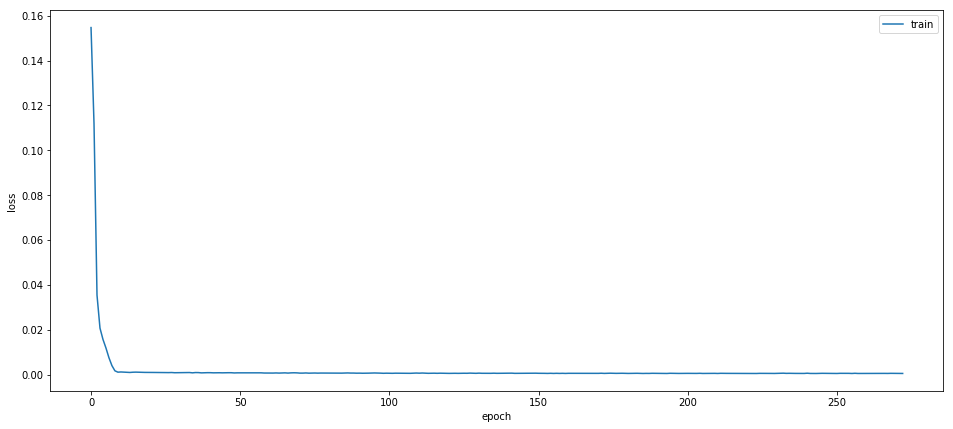

In [22]:
plt.figure(figsize=(16, 7))
plt.plot(train_sonuc.history['loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper right')
plt.show()

# Tahmin ve gerçek sonuçlar

In [23]:
trainPredictPlot = np.empty_like(OHLC_ortalamasi)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[gun_sayisi:len(trainPredict)+gun_sayisi, :] = trainPredict

In [24]:
testPredictPlot = np.empty_like(OHLC_ortalamasi)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(gun_sayisi*2)+1:len(OHLC_ortalamasi)-1, :] = testPredict

In [25]:
OHLC_ortalamasi = scaler.inverse_transform(OHLC_ortalamasi)

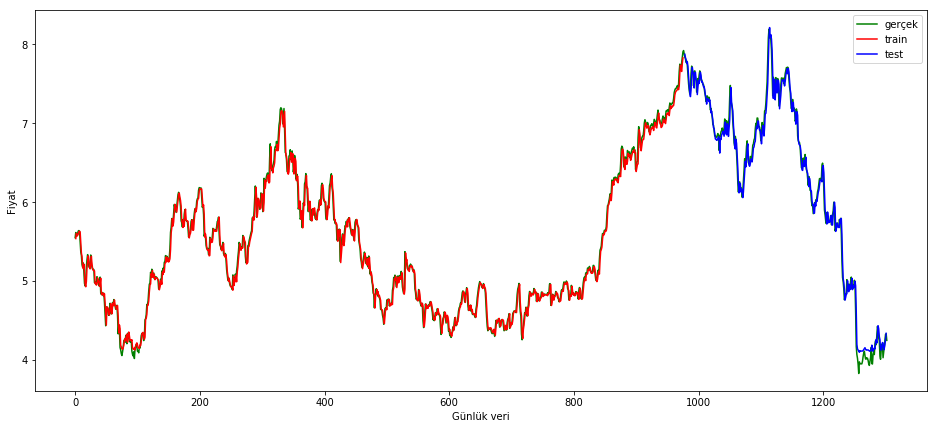

In [26]:
plt.figure(figsize=(16, 7))
plt.plot(OHLC_ortalamasi, 'g', label = 'gerçek')
plt.plot(trainPredictPlot, 'r', label = 'train')
plt.plot(testPredictPlot, 'b', label = 'test')
plt.legend(loc = 'upper right')
plt.xlabel('Günlük veri')
plt.ylabel('Fiyat')
plt.show()

# Yarınki fiyat

In [27]:
son_gun_fiyat = testPredict[-1]
son_gun_fiyat_scaled = son_gun_fiyat/son_gun_fiyat
ertesi_gun_fiyat = model.predict(np.reshape(son_gun_fiyat_scaled, (1,1,1)))
print("Son gün değeri (test set):", np.asscalar(son_gun_fiyat))
print("Ertesi gün tahmin:", np.asscalar(son_gun_fiyat*ertesi_gun_fiyat))

Son gün değeri (test set): 4.336758613586426
Ertesi gün tahmin: 4.357887268066406
